In [ ]:
!pip install pytorch-pretrained-bert
!pip install transformers

In [42]:
import os
import re
import csv
import itertools

import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [7]:
#tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Getting biobert & biobert weights

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

In [9]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [ ]:
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

In [11]:
!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt
config.json				model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt


In [12]:
!ls

biobert_v1.1_pubmed  biobert_weights  sample_data


In [ ]:
'/content/drive/MyDrive/DATA_ML/bionlp_tags.csv'

In [13]:
MAX_LEN = 75
BATCH_SIZE = 32
tokenizer = BertTokenizer(vocab_file='biobert_v1.1_pubmed/vocab.txt', do_lower_case=False)

In [14]:
data = pd.read_csv('/content/drive/MyDrive/DATA_ML/bionlp_tags.csv')
tag_values = data['tags'].values
vocab_len = len(tag_values)
print('Entity Types:',vocab_len)

Entity Types: 74


In [15]:
df_tags = pd.DataFrame({'tags':tag_values})
df_tags.to_csv('bionlp_tags.csv',index=False)
df = pd.read_csv('bionlp_tags.csv')
print('Tag Preview:\n', df)

Tag Preview:
                       tags
0     I-Cellular_component
1   E-Gene_or_gene_product
2   I-Organism_subdivision
3     I-Organism_substance
4   B-Gene_or_gene_product
..                     ...
69                 I-Organ
70                S-Cancer
71            B-Amino_acid
72     S-Anatomical_system
73                     PAD

[74 rows x 1 columns]


In [16]:
class SentenceFetch(object):
  
  def __init__(self, data):
    self.data = data
    self.sentences = []
    self.tags = []
    self.sent = []
    self.tag = []
    
    # make tsv file readable
    with open(self.data) as tsv_f:
      reader = csv.reader(tsv_f, delimiter='\t')
      for row in reader:
        if len(row) == 0:
          if len(self.sent) != len(self.tag):
            break
          self.sentences.append(self.sent)
          self.tags.append(self.tag)
          self.sent = []
          self.tag = []
        else:
          self.sent.append(row[0])
          self.tag.append(row[1])   

  def getSentences(self):
    return self.sentences
  
  def getTags(self):
    return self.tags

In [17]:
corpora = '/content/drive/MyDrive/DATA_ML/bionlp_corpora'
sentences = []
tags = []
for subdir, dirs, files in os.walk(corpora):
    for file in files:
        if file == 'train.tsv':
            path = os.path.join(subdir, file)
            sent = SentenceFetch(path).getSentences()
            tag = SentenceFetch(path).getTags()
            sentences.extend(sent)
            tags.extend(tag)
            
sentences = sentences[0:20000]
tags = tags[0:20000]

In [18]:
print('Sentence Preview:\n',sentences[0])

Sentence Preview:
 ['Reactive', 'oxygen', 'intermediate', '-', 'dependent', 'NF', '-', 'kappaB', 'activation', 'by', 'interleukin', '-', '1beta', 'requires', '5', '-', 'lipoxygenase', 'or', 'NADPH', 'oxidase', 'activity', '.']


In [19]:
def tok_with_labels(sent, text_labels):
  '''tokenize and keep labels intact'''
  tok_sent = []
  labels = []
  for word, label in zip(sent, text_labels):
    tok_word = tokenizer.tokenize(word)
    n_subwords = len(tok_word)

    tok_sent.extend(tok_word)
    labels.extend([label] * n_subwords)
  return tok_sent, labels

tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(sentences, tags)]

In [21]:
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]

In [22]:
len(tok_texts)

20000

In [23]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [24]:
for char in tok_texts:
    print('WordPiece Tokenizer Preview:\n', char)
    break

WordPiece Tokenizer Preview:
 ['Re', '##active', 'oxygen', 'intermediate', '-', 'dependent', 'N', '##F', '-', 'ka', '##ppa', '##B', 'activation', 'by', 'inter', '##le', '##uki', '##n', '-', '1', '##bet', '##a', 'requires', '5', '-', 'lip', '##ox', '##y', '##gen', '##ase', 'or', 'N', '##AD', '##P', '##H', 'o', '##xi', '##das', '##e', 'activity', '.']


In [25]:
tag_values = list(set(itertools.chain.from_iterable(tags)))
tag_values.append("PAD")

tag2idx = {t: i for i,t in enumerate(tag_values)}

In [26]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [27]:
# attention masks make explicit reference to which tokens are actual words vs padded words
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [29]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2021, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2021, test_size=0.1)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [30]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [31]:
config = BertConfig.from_json_file('biobert_v1.1_pubmed/config.json')
tmp_d = torch.load('biobert_v1.1_pubmed/pytorch_model.bin', map_location=device)
state_dict = OrderedDict()

for i in list(tmp_d.keys())[:199]:
    x = i
    if i.find('bert') > -1:
        x = '.'.join(i.split('.')[1:])
    state_dict[x] = tmp_d[i]

In [32]:
class BioBertNER(nn.Module):

  def __init__(self, vocab_len, config, state_dict):
    super().__init__()
    self.bert = BertModel(config)
    self.bert.load_state_dict(state_dict, strict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    encl = encoded_layer[-1]
    out = self.dropout(encl)
    out = self.output(out)
    return out, out.argmax(-1)

In [ ]:
model = BioBertNER(vocab_len,config,state_dict)
model.to(device)

In [34]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)
epochs = 3
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [35]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    for step,batch in enumerate(data_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs,y_hat = model(b_input_ids,b_input_mask)
        
        _,preds = torch.max(outputs,dim=2)
        outputs = outputs.view(-1,outputs.shape[-1])
        b_labels_shaped = b_labels.view(-1)
        loss = loss_fn(outputs,b_labels_shaped)
        correct_predictions += torch.sum(preds == b_labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [36]:
def model_eval(model,data_loader,loss_fn,device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
        
            outputs,y_hat = model(b_input_ids,b_input_mask)
        
            _,preds = torch.max(outputs,dim=2)
            outputs = outputs.view(-1,outputs.shape[-1])
            b_labels_shaped = b_labels.view(-1)
            loss = loss_fn(outputs,b_labels_shaped)
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())
        
    
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [37]:
%%time
history = defaultdict(list)
best_accuracy = 0
normalizer = BATCH_SIZE*MAX_LEN
loss_values = []

for epoch in range(epochs):
    
    total_loss = 0
    print(f'======== Epoch {epoch+1}/{epochs} ========')
    train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
    train_acc = train_acc/normalizer
    print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
    total_loss += train_loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader)  
    loss_values.append(avg_train_loss)
    
    val_acc,val_loss = model_eval(model,valid_dataloader,loss_fn,device)
    val_acc = val_acc/normalizer
    print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

======== Epoch 1/3 ========
Train Loss: 0.15064973180342736 Train Accuracy: 0.9563291888691534
Val Loss: 0.046919943262187264 Val Accuracy: 0.9724338624338625
======== Epoch 2/3 ========
Train Loss: 0.039140151739186654 Train Accuracy: 0.9819671403197159
Val Loss: 0.0396994524709289 Val Accuracy: 0.973478835978836
======== Epoch 3/3 ========
Train Loss: 0.02930726797599511 Train Accuracy: 0.9846055358200119
Val Loss: 0.03774832236388373 Val Accuracy: 0.9739880952380953
CPU times: user 7min 38s, sys: 7min 25s, total: 15min 4s
Wall time: 15min 4s


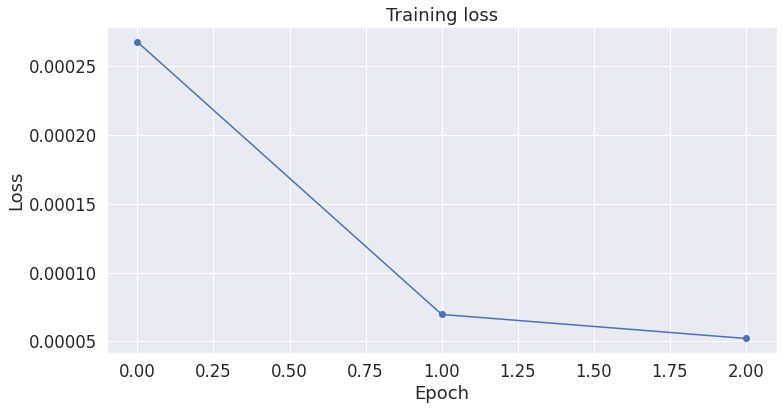

In [38]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# learning curve
plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#Testing

In [39]:
text = """In addition to their essential catalytic role in protein biosynthesis, aminoacyl-tRNA synthetases participate in numerous other functions, including regulation of gene expression and amino acid biosynthesis via transamidation pathways. Herein, we describe a class of aminoacyl-tRNA synthetase-like (HisZ) proteins based on the catalytic core of the contemporary class II histidyl-tRNA synthetase whose members lack aminoacylation activity but are instead essential components of the first enzyme in histidine biosynthesis ATP phosphoribosyltransferase (HisG). Prediction of the function of HisZ in Lactococcus lactis was assisted by comparative genomics, a technique that revealed a link between the presence or the absence of HisZ and a systematic variation in the length of the HisG polypeptide. HisZ is required for histidine prototrophy, and three other lines of evidence support the direct involvement of HisZ in the transferase function. (i) Genetic experiments demonstrate that complementation of an in-frame deletion of HisG from Escherichia coli (which does not possess HisZ) requires both HisG and HisZ from L. lactis. (ii) Coelution of HisG and HisZ during affinity chromatography provides evidence of direct physical interaction. (iii) Both HisG and HisZ are required for catalysis of the ATP phosphoribosyltransferase reaction. This observation of a common protein domain linking amino acid biosynthesis and protein synthesis implies an early connection between the biosynthesis of amino acids and proteins."""

In [43]:
sent_text = nltk.sent_tokenize(text)

In [44]:
tokenized_text = []
for sentence in sent_text:
    tokenized_text.append(nltk.word_tokenize(sentence))

In [45]:
def tokenize_and_preserve(sentence):
    tokenized_sentence = []
    
    for word in sentence:
        tokenized_word = tokenizer.tokenize(word)   
        tokenized_sentence.extend(tokenized_word)

    return tokenized_sentence

In [46]:
tok_texts = [
    tokenize_and_preserve(sent) for sent in tokenized_text
]

In [47]:
input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts]
input_attentions = [[1]*len(in_id) for in_id in input_ids]

In [48]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[1])
new_tokens, new_labels = [], []
for token in tokens:
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        
        new_tokens.append(token)

In [49]:
actual_sentences = []
pred_labels = []
for x,y in zip(input_ids,input_attentions):
    x = torch.tensor(x).cuda()
    y = torch.tensor(y).cuda()
    x = x.view(-1,x.size()[-1])
    y = y.view(-1,y.size()[-1])
    with torch.no_grad():
        _,y_hat = model(x,y)
    label_indices = y_hat.to('cpu').numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(x.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    actual_sentences.append(new_tokens)
    pred_labels.append(new_labels)

In [50]:
for token, label in zip(actual_sentences, pred_labels):
    for t,l in zip(token,label):
        print("{}\t{}".format(t, l))

In	O
addition	O
to	O
their	O
essential	O
catalytic	O
role	O
in	O
protein	O
biosynthesis	O
,	O
aminoacyl	O
-	O
tRNA	O
synthetases	O
participate	O
in	O
numerous	O
other	O
functions	O
,	O
including	O
regulation	O
of	O
gene	O
expression	O
and	O
amino	O
acid	O
biosynthesis	O
via	O
transamidation	O
pathways	O
.	O
Herein	O
,	O
we	O
describe	O
a	O
class	O
of	O
aminoacyl	O
-	O
tRNA	O
synthetase	O
-	O
like	O
(	O
HisZ	O
)	O
proteins	O
based	O
on	O
the	O
catalytic	O
core	O
of	O
the	O
contemporary	O
class	O
II	O
histidyl	O
-	O
tRNA	O
synthetase	O
whose	O
members	O
lack	O
aminoacylation	O
activity	O
but	O
are	O
instead	O
essential	O
components	O
of	O
the	O
first	O
enzyme	O
in	O
histidine	O
biosynthesis	O
ATP	O
phosphoribosyltransferase	I-Protein
(	O
HisG	B-Protein
)	O
.	O
Prediction	O
of	O
the	O
function	O
of	O
HisZ	B-Protein
in	O
Lactococcus	O
lactis	O
was	O
assisted	O
by	O
comparative	O
genomics	O
,	O
a	O
technique	O
that	O
revealed	O
a	O
link	O
between	O
the	O
presence	O
or	O
the	O
absence	O
of	O

In [52]:
model_save = 'BIONER_classifier.pt'
path = F"{model_save}" 
torch.save(model.state_dict(), path)